In [20]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>



# demodulation: energy & effective bandwidth

**Demodulation**

The demodulated velocity $\hat u (t)$ field of a raw velocity $u(t)$ is obtained according to:

$
\begin{align}
\hat u(t) &= 2 \mathcal{L_\delta} \Big \{ u(t) e^{-i\phi(t)} \Big \},  \label{eq:demod}\\
\phi(t) &= \int^t \omega(t') dt', \\
\end{align}
$

where $\mathcal{L_\delta}$ is a low pass filter with cutoff frequency $\delta$, $\omega$ is the frequency of interest which may be a function of drifter position for near-inertial variability.

**Phase resolved signal**

The phase resolved signal is computed according to:

$
\begin{align}
u_\omega(t) &= \Re \Big \{ \hat u(t) e^{i\phi(t)} \Big \},
\end{align}
$

**Effective bandwidth**

This approach is approximately equivalent to bandpass filtering around the central frequency $\omega$ with bandwidth $2\delta$.
Any signal with frequency $\omega\pm\delta$ will indeed go through ($\ref{eq:demod}$).

**Standard deviation / energy**

The standard deviation (energy) is obtained via:

$
\begin{align}
E &= \frac{1}{2} \langle | \hat u(t) |^2 \rangle,
\end{align}
$

**Synthetic signals**

We consider two types of signals

- modulated sinusoidal signal with central frequency $\omega_0=2$cpd
- white noise

Timeseries are generated with unit standard deviation

In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt

import drifters.sigp as sigp
import sstats.tseries as ts

---
## generate synthetic signals

In [3]:
# timeline: 1000 days with hourly sampling
dt = 1 / 24  # time sampling in days
t = (1000, dt)
Nd = 10 # number of draws

In [4]:
# white noise
x_w = (ts.normal((100, 1.0 / 24), 0.0, draws=Nd, seed=0)
       .rename("x_w")
       .compute()
)
x_w = x_w/x_w.std("time")

In [5]:

# periodical signal
omega0 = 2*np.pi*2 # semi-diurnal
T = 100 # incoherence timescale
E_2 = lambda omega: (omega**2+omega0**2 + T**-2) \
        /( (omega**2-omega0**2)**2 +  T**-2 * (omega**2+omega0**2) + T**-4 )

uv_2 = (ts.spectral(t, spectrum=E_2, draws=Nd)
         .compute()
)
x_2 = np.real(uv_2).rename("x_2")
x_2 = x_2/x_2.std("time")


/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [6]:
ds = xr.merge([x_w, x_2])

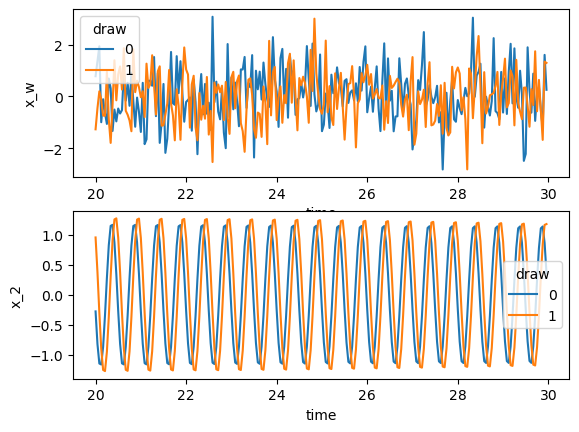

In [7]:
_ds = ds.isel(time=slice(24*20,24*30), draw=[0,1])

fig, axes = plt.subplots(2,1)
_ds.x_w.plot.line(x="time", ax=axes[0])
_ds.x_2.plot.line(x="time", ax=axes[1])

---
## demodulation

In [10]:
def build_lowpass_filter(bandwidth, T, dt):
    """build a low pass filter

    Parameters
    ----------
    bandwidth: float
        filter bandwidth in cpd
    T: float
        Filter length in days
    Returns
    ----------
    F: dict
        Dictionnary containing:
            the filter ("h") and a corresponding time line ("t")
            the filter frequency response ("H") and corresponding frequencies ("f")
            a lambda function to apply the filter
    """
    h = sigp.generate_filter("low", bandwidth=bandwidth, T=T, dt=dt)
    t = np.arange(h.size) * dt - T / 2
    H, f = sigp.filter_response(h, dt=dt)
    filt = lambda v: np.convolve(v, h, mode="same")
    return dict(h=h, t=t, H=H, f=f, filt=filt)

In [11]:
Tf = 30 # default filter length in days
bandwidth = 0.2

f = build_lowpass_filter(bandwidth, Tf, dt)

Text(0.5, 0, '[cpd]')

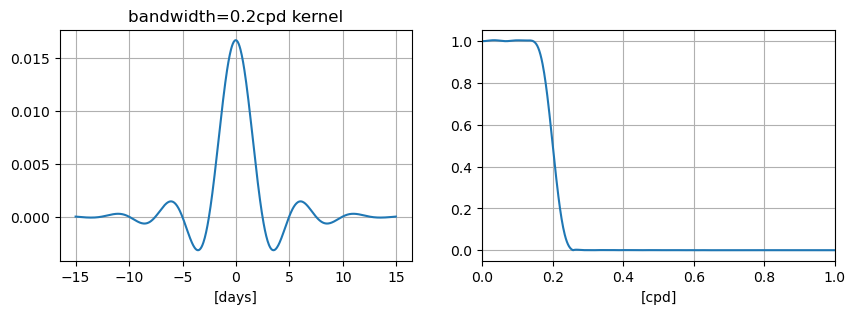

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

ax = axes[0]
ax.plot(f["t"], f["h"])
ax.grid()
ax.set_xlabel("[days]")
ax.set_title(f"bandwidth={bandwidth}cpd kernel")

ax = axes[1]
ax.plot(f["f"], np.abs(f["H"]))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.grid()
ax.set_xlabel("[cpd]")

---

## apply demodulation

In [13]:
def demodulate(x,
):
    omega = x.time*0 + omega0/86400 # !! source of error ?
    phase = omega.cumsum() * dt*86400

    x_phi = (x * np.exp(-1j * phase)).values
    assert x_phi.data.shape[0]==ds.time.size, "data needs to be reshaped"
    x_demod = np.apply_along_axis(f["filt"], 0, x_phi) * 2 # !! factor 2
    #x_demod = xr.apply_ufunc(demod, x, dask="parallelized", output_dtypes=[complex], input_core_dims=[["time"]], output_core_dims=[["time"]])
    x_real, x_imag = cplx_split(x_demod*np.exp(1j * phase.values[:,None]))
    return x_demod, x_real, x_imag

def cplx_split(v):
    """split complex number into real, imaginary parts"""
    return np.real(v), np.imag(v)

In [14]:
x_demod, x_real, x_imag = demodulate(ds.x_w)
ds["x_w_demod"] = (ds.x_w.dims, x_demod)
ds["x_w_real"] = (ds.x_w.dims, x_real)
ds["x_w_imag"] = (ds.x_w.dims, x_imag)

x_demod, x_real, x_imag = demodulate(ds.x_2)
ds["x_2_demod"] = (ds.x_w.dims, x_demod)
ds["x_2_real"] = (ds.x_w.dims, x_real)
ds["x_2_imag"] = (ds.x_w.dims, x_imag)

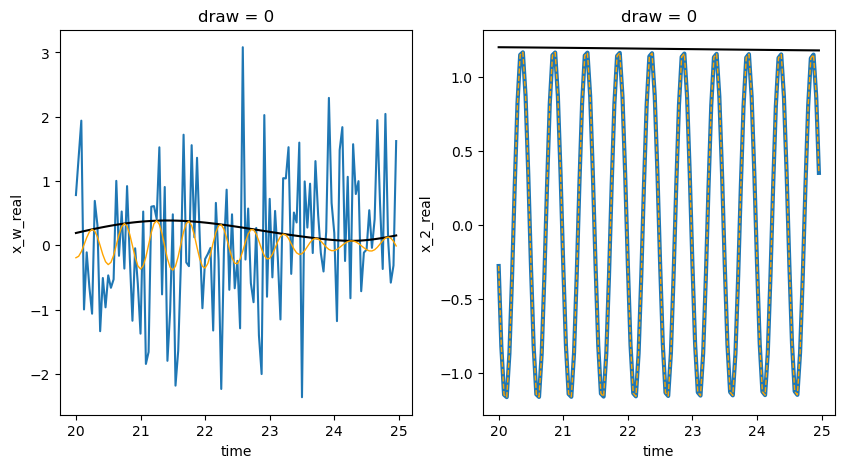

In [16]:
_ds = ds.isel(time=slice(24*20,24*25), draw=0)

fig, axes = plt.subplots(1,2, figsize=(10,5))
_ds.x_w.plot.line(x="time", ax=axes[0])
np.abs(_ds.x_w_demod).plot.line(x="time", ax=axes[0], color="k")
_ds.x_w_real.plot.line(x="time", ax=axes[0], lw=1,color="orange", ls="-")

_ds.x_2.plot.line(x="time", ax=axes[1], lw=3)
np.abs(_ds.x_2_demod).plot.line(x="time", ax=axes[1], color="k")
_ds.x_2_real.plot.line(x="time", ax=axes[1], lw=1,color="orange", ls="--")

---
### compute average energy

Should find:

- modulated sinusoidal signal: should recover full variance
- white noise: 2xbandwidth/Nyquist = 2x 0.1*2*1/24 = 0.033


In [17]:
ds["E_w"] = 0.5*(np.abs(ds["x_w_demod"])**2).mean("time")
ds["E_2"] = 0.5*(np.abs(ds["x_2_demod"])**2).mean("time")

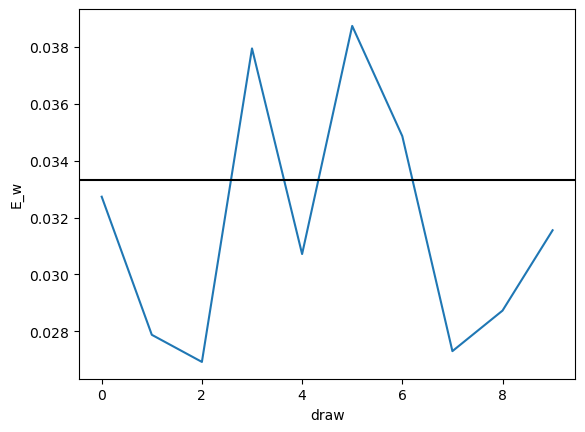

In [18]:
fig, ax = plt.subplots()
ds["E_w"].plot()
ax.axhline(2*bandwidth*2*dt, color="k")

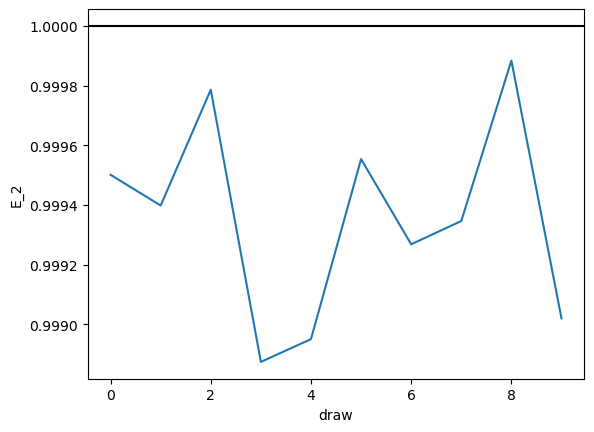

In [19]:
fig, ax = plt.subplots()
ds["E_2"].plot()
ax.axhline(1, color="k")